In [138]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
import math
import datetime
%matplotlib inline

# グラフを横長にする
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

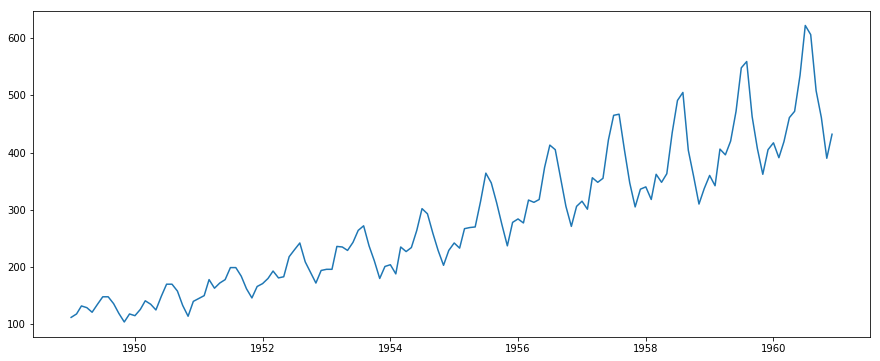

In [139]:
# 日付形式で読み込む
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
data = pd.read_csv('../01_input/AirPassengers.csv', index_col='Month', date_parser=dateparse, dtype='float')

# 日付形式にする
ts = data['#Passengers'] 
ts.head()

# プロット
plt.plot(ts)

In [140]:
data.columns

Index(['#Passengers'], dtype='object')

In [141]:
data.head(3)

,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0


In [179]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

## 対数系列の確認

In [147]:
ts2 = data['#Passengers'].map(lambda x :math.log(x))

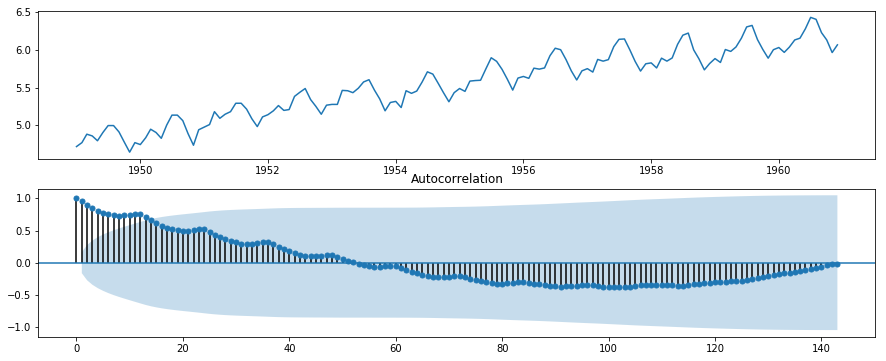

In [148]:
# 対数系列
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(ts2)

#　対数系列（自己相関）
ax2 = fig.add_subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(ts2,ax=ax2)

plt.show()

## 対数差分系列の確認

In [168]:
ts3 = ts2.diff().dropna()

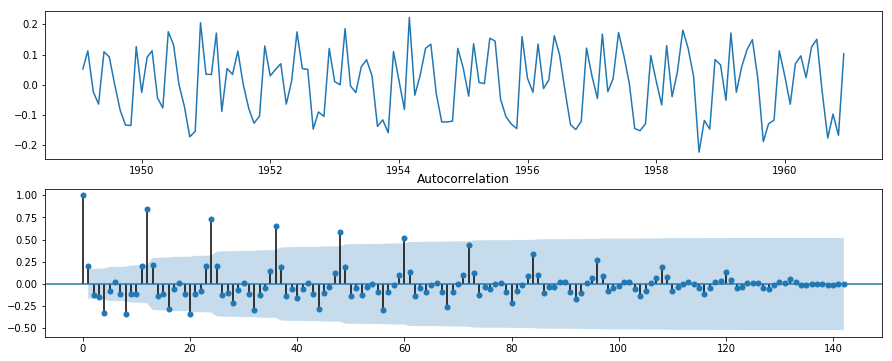

In [169]:
#　対数差分系列
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(ts3)

#　対数差分系列（自己相関）
ax2 = fig.add_subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(ts3,ax=ax2)

plt.show()

## 季節差分系列の確認

In [171]:
ts4 = ts3.diff(periods=12).dropna()

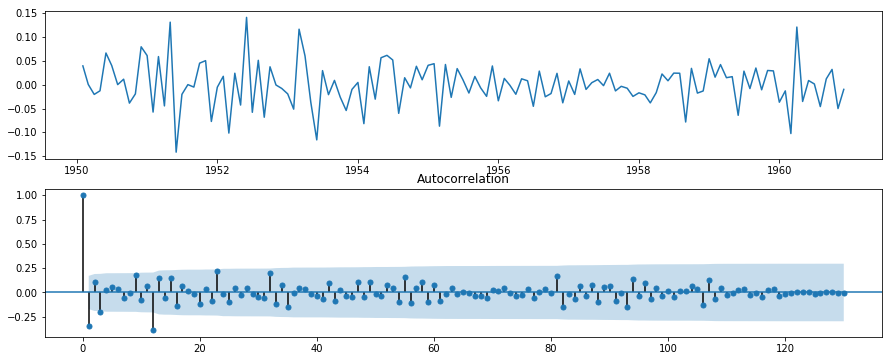

In [175]:
#　対数差分系列
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(ts4)

#　対数差分系列（自己相関）
ax2 = fig.add_subplot(2, 1, 2)
sm.graphics.tsa.plot_acf(ts4,ax=ax2)

plt.show()

## パラメータチューニング

In [181]:
# 自動ARMAパラメータ推定関数
res_selection = sm.tsa.arma_order_select_ic(ts３, ic='aic', trend='nc')
res_selection

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


{'aic':             0           1           2
 0         NaN -238.725394 -240.846550
 1 -236.597874 -242.626208 -248.864829
 2 -238.521906 -251.463510 -279.969512
 3 -237.644076 -250.449948 -251.799920
 4 -249.973573 -253.153939 -256.435676, 'aic_min_order': (2, 2)}

## フィッティング

In [182]:
# SRIMAモデル作成その１
sarimax = sm.tsa.SARIMAX(ts2, 
                         order=(2, 1, 2),
                         seasonal_order=(1, 1, 1, 12),
                         enforce_stationarity = False,
                         enforce_invertibility = False
                        ).fit()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [183]:
print(sarimax.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 12)   Log Likelihood                 217.887
Date:                            Mon, 15 Jul 2019   AIC                           -421.774
Time:                                    14:40:13   BIC                           -400.985
Sample:                                01-01-1949   HQIC                          -413.326
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6800      0.252     -2.694      0.007      -1.175      -0.185
ar.L2          0.0893      0.207   

In [184]:
# モデルの残差成分
sarimax_resid = sarimax.resid

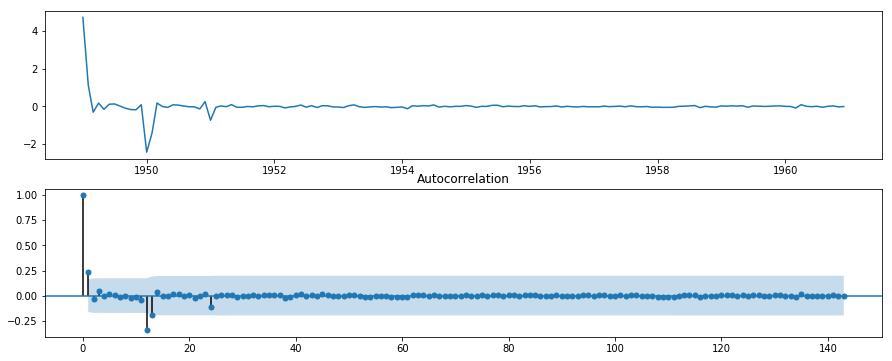

In [189]:
# モデル残差のコレログラム
fig = plt.figure()

# 自己相関(ACF)のグラフ
ax1 = fig.add_subplot(2,1,1)
plt.plot(sarimax_resid)

# 自己相関(ACF)のグラフ
ax2 = fig.add_subplot(2,1,2)
sm.graphics.tsa.plot_acf(sarimax_resid, ax=ax2)

plt.show()

In [190]:
print(sarimax.aic)

-421.7735154520645


## 確認

In [203]:
# 予測
sarimax_pred = sarimax.predict('1950-05', '1960-12') 
sarimax_pred2 = sarimax_pred.map(lambda x: math.exp(x))

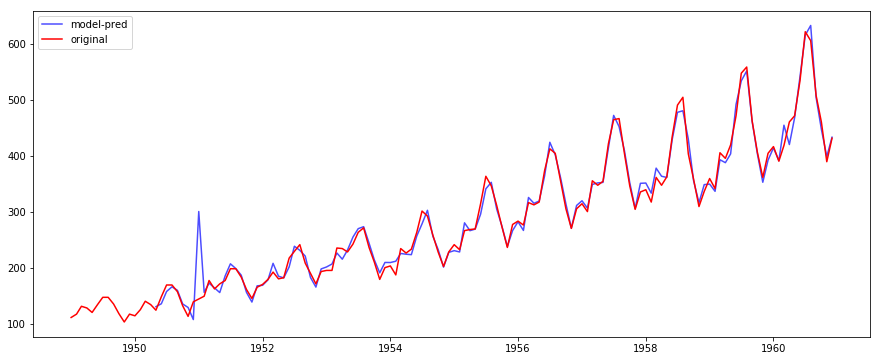

In [204]:
# モデルの値でプロット
fig = plt.figure()
plt.plot(sarimax_pred2, c="b", label="model-pred", alpha=0.7)

plt.plot(ts, label="original", c='r')
plt.legend(loc='best')